# Finding Optimal Locations for Polling Stations in San Diego County

**Contributors**: Renaldy Herlim, Siddhi Patel

# Table of Contents<a class="anchor" id="toc"></a>
* [Overview](#overview)
* [Data Cleaning](#cleaning-data)
* [EDA](#eda)
* [Analysis](#analysis)
* [Location-Allocation](#location-allocation)
    * [Results](#loc-results)
* [Geoenrich](#geoenrich)
* [Summary](#summary)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

In [26]:
#Importing libraries

#ArcGIS imports that are required in our project
from arcgis import GIS
from arcgis.features import GeoAccessor
from arcgis.mapping import WebMap #For interactive Web Map visualizations
from arcgis.geometry import *
import arcgis.network as network 
from arcgis.features import FeatureLayer, Feature, FeatureSet, FeatureCollection, find_locations
from arcgis.features.manage_data import dissolve_boundaries #For data cleaning purposes
from arcgis.geoenrichment import * #Libraries for geoenriching our datasets

%matplotlib inline
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

agol = GIS(username='rherlim_dsc170fa20') #For importing Feature Layers from ArcGIS Online

Enter password: ········


# Overview<a class="anchor" id="overview"></a>

In this project, we wanted to explicitly answer these hypothesis questions:
- Using GIS, can we optimize the placement of polling locations to emphasize the weight of permanent in-person voters? 
- Do our planned locations differ from that of the official 2020 polling locations?

Our plan of attack to answer these questions is to format the problem as a location-allocation problem, where we weight our locations based on the rate of in-person voters in a certain election precinct. This will help us answer the first question since we’ll be emphasizing the weight of permanent in-person voters this way. We hope to find that the polling locations we develop will differ from that of the official 2020 polling locations because we used a more quantitative approach in determining their locations. This finding would be important so that in the future, elections departments can efficiently place polling locations in areas that are more equitable for in-person voters. 

This project is catered towards local government departments that are in charge of finding polling places for elections. According to San Francisco’s Department of Elections, a number of election precincts are set up based on voter registration during election years. It is then up to the Elections Department to find volunteers for polling locations within those precincts. However, that essentially means that polling locations are chosen at random within election precincts rather than intentionally chosen to maximize in-person voter attendance. In this project, we aim to plot polling locations within precincts that can maximize voter attendance based on voter registration data. This would be beneficial in order to increase the weight of in-person voters and to provide them with more equitable polling locations. 

Lastly, we chose to emulate the 2020 Elections due to the additional COVID-19 regulations that caused a decrease in the number of in-person polling stations. We wanted to show that despite additional regulations, location-allocation can still be used to find polling station locations. It would also help us filter out large layers so that we could finish this project in a timely fashion. We'll discuss possible broadening of this project in the conclusion as well as discuss the limits of doing a project on a non-2020 elections cycle at least with the analysis systems that we were provided.   

### Background and Literature

1. In this KPBS article titled “Some Neighborhoods Hit Harder Than Others As COVID-19 Forces Deep Cuts In Polling Places,” there are many details on how the number of polling locations were reduced in different zip codes. We also learn that the SD county didn’t take ZIP code data or voter registration data into account when determining new polling locations after reducing the number of polling locations due to COVID-19. We also learned how we could possibly filter out locations based on these three sentences: “His team aimed to put polling places at well-known sites and accounted for factors such as available power, sufficient parking and the size of the space. Most of the locations chosen are at least 2,000 square feet, larger than in prior elections. Vu said his team did not consider vote-by-mail patterns.”
    - Link: https://www.kpbs.org/news/2020/oct/30/some-neighborhoods-hit-harder-others-covid-19-forc/


2. This article titled “Five Ways the November Election Could Be Odder Than Ever”, helped us find that we need to at least place polling locations so that there is 1 for every 10,000 people. Instead, we’ll find the same number of polling locations that were found in the 2020 elections for SD county, which is 253. This article also details possible locations that we can have qualitatively, such as schools and recreation centers for superpolls. 
    - Link: https://www.voiceofsandiego.org/topics/politics/five-ways-the-november-election-could-be-odder-than-ever/


3. This article titled “How geospatial data can improve US elections”, gives us reason to believe that using GIS technology will be the future of placing polling locations. It reassures us that using GIS to solve a problem like this may not be such a weird idea. 
    - Link: http://geospatial-solutions.com/how-geospatial-data-can-improve-us-elections/


4. This ESRI article titled “COVID-19: Location Intelligence Guides Adaptation of Voting Practices”, details how election officials used GIS to analyze polling locations to avoid high-risk venues and increase physical distancing. In particular, Maricopa County in Arizona utilized GIS to visualize location centers and calculate likely travel times. With this article, we can see that many elections departments have already started using GIS for various reasons. Perhaps SD County has too and just wasn’t mentioned in this article, but we want to experiment with ways that we can use it. 
    - Link: https://www.esri.com/about/newsroom/blog/location-intelligence-helps-governments-adapt-elections/


5. A similar project was done on the previous election, however, we will improve on the concept of this project by incorporating COVID-19 precautions data as well as look into data on San Diego demographics, race, income, and other data sources relating to San Diego election data. This project was not done in a Jupyter notebook so it’s a bit hard to modify the code itself, but we can use this as an inspiration for what steps we need to take to perform location-allocation on elections data. 
    - Link: https://github.com/MattWLeonard/PollingPlaces_and_VotingPrecincts


Overall, these sources helped us find how we can filter our candidate locations based on past patterns. We also were reassured that other counties were using ArcGIS as well. An explanation for how each article each helped individually is located above. We didn’t really use the code from the last source because we found that it was in a format that we didn’t really use in class, but we did use it for inspiration on the sequence of steps we should take to solve our location-allocation problem. 


### Python libraries and ArcGIS modules used

- __Pandas__ - to perform in-depth analysis as well as get a better understanding of the spatial dataframes and shapefiles that we are going to be importing into our project notebook. Pandas will help us pre-process the data better. 
- __Matplotliib and Seaborn__ - to visualize our data nicely.
- __ArcGIS Features Manage_data module__ - to use dissolve_boundaries in order to get the correct amount of polling locations.
- __ArcGIS Geoenrichment Module__ - to get more information regarding areas in San Diego county, like getting demographic, income, race, and other data on polling locations. This helps us get a better idea of how our polling locations differ from that of the official polling locations. 
- __ArcGIS Features Analysis Module__ - to use find_existing_locations, merge_layers, and overlay_layers as well as aggregate_points and create_buffers to summarize and get statistics on certain areas of interests and to find relevant voting locations that we are going to use in our analysis (NOTE: We did much of these functions in ArcGIS Online since it was easier to visualize. More information included below).
- __ArcGIS Network Module__ - In order to use the feature solve_location_allocation. (NOTE: We did much of the location allocation in ArcGIS Online since it was easier to visualize. More information included below)
- __ArcGIS Storymaps__ - to create our presentation for the project findings, we can easily store all our map layers in one location as well as present our analysis in a more organized and presentable way.

Compared to our original list from the proposal, we took out our use of the sci-kit learn package because we chose not to go down the machine learning route of finding our features. We did this because we found that there were ample articles that could indicate which sources we could use as features. We also used dissolve_boundaries after closely looking at the data for the in-person polling station locations (more details below). We also imported seaborn to get nice visualizations for some of our EDA. 


## Datasets

1. __San Diego County 2020 Polling Locations__: This point layer is published by SanGIS to depict coordinates for the polling locations in SD county. 
    - Link: https://ucsdonline.maps.arcgis.com/home/item.html?id=c06c671a9bab46c7a4d049b104836f11
    - Number of Spatial Objects: 573


2. __San Diego County 2020 Elections Precincts__: This layer would help us see the boundaries of the precincts for 2020. We can compare these precincts to demographic data from the Census and see if certain incomes or races are clumped into different precincts. 
    - Link: https://ucsdonline.maps.arcgis.com/home/item.html?id=c06c671a9bab46c7a4d049b104836f11
    - Number of Spatial Objects: 1,153
    

3. __SANDAG San Diego County Existing Locations Data__: This dataset contains all the existing locations in San Diego county, categorized into the type of institutions (Education, Recreational, etc.). Last updated December 2019. 
    - [Sandag Link](https://sdgis-sandag.opendata.arcgis.com/datasets/existing-landuse-1)
    - [Feature Layer](https://ucsdonline.maps.arcgis.com/home/item.html?id=f501596b3625419cbf0b009bece33bdd)
    - [GeoJSON Format](https://gis.sandag.org/sdgis/rest/services/LandUse/Existing_LandUse/MapServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json)
    - Number of spatial objects: 119,298

Since the proposal phase, we used all of the datasets except the [parcels dataset](https://ucsdonline.maps.arcgis.com/home/item.html?id=2b0c9d1dbb7b4f44b9f2beb5d74c2780). Due to the sheer size of this dataset, we chose to replace it with the existing locations dataset. After a whole night of trying to find candidate locations using this layer, we realized that ArcGIS will use at most 100,000 points for performing a spatial join and this dataset was too large even after filtering for relevant locations. So this dataset was NOT used in the final notebook of this project. 

We didn’t have many concerns with our datasets since we attained them mostly from official San Diego courses (SANDAG and SanGIS). The only concern was that the existing locations dataset used EPSG:3857 and that means the area of the spatial objects was given in square meters. We quickly resolved this issue by converting 2000 square feet to square meters and instead found buildings with areas greater than 185.8061 square meters. 

One piece of data that might have been helpful to address research questions may have been the specific locations that were used as official candidates for polling stations for the 2020 elections. This would’ve helped us pick better candidate locations for polling stations because we want to emulate the possible locations used by SD’s elections department. We weren’t able to access this data because SD county has not released it to our knowledge, but we used our past research in the above articles to help us decide which locations could be used as potential polling locations. 


We have three main datasets that we are loading in from ArcGIS for this project. The first dataset is the election polls layer, the second is the precincts boundaries layer, and lastly the existing land use layer. The election polls and precincts layers are stored in the same feature layer collection and the existing land use layer is separate, therefore we see two imported contents.

In [2]:
election_polls_and_precincts = agol.content.get('c06c671a9bab46c7a4d049b104836f11')
existing_land_use = agol.content.get('f501596b3625419cbf0b009bece33bdd')

<Item title:"Election_Polls_and_Precincts_NOV_2020_rev_09222020" type:Feature Layer Collection owner:ian.dawes>
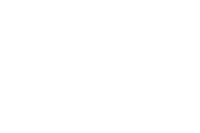

In [3]:
election_polls_and_precincts

<Item title:"Existing Land Use" type:Feature Layer Collection owner:rherlim_dsc170fa20>
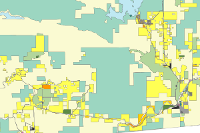

In [4]:
existing_land_use

## Data Cleaning<a class="anchor" id="cleaning-data"></a>

### Polling Locations Dataset

In [5]:
#Polling layer in spatial dataframe preview
polling_locations_fl = election_polls_and_precincts.layers[0]
polling_locations_sdf = polling_locations_fl.query().sdf
display(polling_locations_sdf.head())
print(polling_locations_sdf.shape)
print('\nThe number of existing polling locations in San Diego county before dissolving is: {0}'.format(polling_locations_sdf.shape[0]))

OBJECTID  POLL_ZIP POLL_TYPE  USED    CONS_NAME      CONS  SEQ  LOC_ID  \
0         1     92154       SCH     1         OTAY  390410.0  156      95   
1         2     91911       SCH     2  CHULA VISTA  529810.0  512     233   
2         3     91911       SCH     1  CHULA VISTA  529520.0  511     205   
3         4     91910       SCH     2  CHULA VISTA  525110.0  496     198   
4         5     91913       SCH     1  CHULA VISTA  531890.0  523     212   

      BT  DIV  ...  NEXTELECT    REGDATE CONTACT  PHONE EMAIL  \
0  586.0  R2A  ... 2020-11-03 2020-10-19    None   None  None   
1  575.0  R2A  ... 2020-11-03 2020-10-19    None   None  None   
2  574.0  R2A  ... 2020-11-03 2020-10-19    None   None  None   
3  570.0  R2A  ... 2020-11-03 2020-10-19    None   None  None   
4  803.0  R2A  ... 2020-11-03 2020-10-19    None   None  None   

                                          SMPLBALLOT  \
0  https://www.sdvote.com/content/rov/en/viewsamp...   
1  https://www.sdvote.com/content/rov/en/viewsamp...   
2  https://www.sdvote.com/content/rov/en/viewsamp...   
3  https://www.sdvote.com/content/rov/en/viewsamp...   
4  https://www.sdvote.com/content/rov/en/viewsamp...   

                                             CHK_REG LASTUPDATE LASTEDITOR  \
0  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
1  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
2  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
3  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
4  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   

                                               SHAPE  
0  {"x": 6315511.083749011, "y": 1793564.17991675...  
1  {"x": 6304255.891036347, "y": 1802164.87925075...  
2  {"x": 6313155.4329485, "y": 1804478.3188495934...  
3  {"x": 6302046.04735893, "y": 1808767.378841012...  
4  {"x": 6335599.43891342, "y": 1810993.571239009...  

[5 rows x 30 columns]

(573, 30)

The number of existing polling locations in San Diego county before dissolving is: 573


It looks like the dataset contains 573 in-person polling station locations. We know that this number is too high, considering that our previous research indicates that there were only 235 locations for polling stations in San Diego County for 2020. We'll be investigating this further below. 

### Cleaning Polling Locations Dataset

In [6]:
# helps us get an idea of what the column names are
polling_locations_sdf.columns

Index(['OBJECTID', 'POLL_ZIP', 'POLL_TYPE', 'USED', 'CONS_NAME', 'CONS', 'SEQ',
       'LOC_ID', 'BT', 'DIV', 'SRVD', 'CC', 'FSR', 'POLLINGID', 'NAME',
       'FULLADD', 'CITY', 'STATE', 'OPERHOURS', 'HANDICAP', 'NEXTELECT',
       'REGDATE', 'CONTACT', 'PHONE', 'EMAIL', 'SMPLBALLOT', 'CHK_REG',
       'LASTUPDATE', 'LASTEDITOR', 'SHAPE'],
      dtype='object')

In [7]:
# getting the total number of precincts that are assigned to our polling locations
print('The number of total precincts assigned to all of the polling location: {0}'.format(len(polling_locations_sdf['CONS'].unique())-1))

The number of total precincts assigned to all of the polling location: 572


We did this to find out how many precincts in San Diego county are assigned to in-perosn polling locations. Every precinct is assigned to a polling location so our precinct layer should match up to having 572 rows. In the later parts of the notebook, we will clean the precincts dataset and explore how many precincts there are in San Diego county to confirm our claim.

We noticed that 1 address is tied to many locations so we decided to dig further. As you can see below, the address "1 WEST TRIBAL RD" contained multiple row values. To figure out why there were multiple rows for one address, we checked to see which column values differed. 

In [8]:
# helps us figure out which columns have different values for an example address with multiple rows
# this will help us find out how we want to dissolve the dataframe

def find_diff_columns(df):
    columns = []
    for column in df.columns:
        for row in df[column].to_list():
            for new_row in range(len(df[column].to_list())-1):
                if df[column].to_list()[new_row] != row:
                    if column not in columns:
                        columns.append(column)
    return columns
            
        
display(polling_locations_sdf[polling_locations_sdf['FULLADD'] == '1 WEST TRIBAL RD'])

print("Columns that don't match:" + 
      str(find_diff_columns(polling_locations_sdf[polling_locations_sdf['FULLADD'] == '1 WEST TRIBAL RD'])))

OBJECTID  POLL_ZIP POLL_TYPE  USED CONS_NAME      CONS  SEQ  LOC_ID  \
126       127     92082       BUS     5      PALA  443050.0  343     151   
309       310     92082       BUS     5      PALA  444890.0  349     151   
424       425     92082       BUS     5      PALA  445940.0  350     151   
498       499     92082       BUS     5      PALA  447170.0  351     151   
539       540     92082       BUS     5      PALA  448020.0  352     151   

        BT  DIV  ...  NEXTELECT    REGDATE CONTACT  PHONE EMAIL  \
126  495.0  R1A  ... 2020-11-03 2020-10-19    None   None  None   
309  490.0  R1A  ... 2020-11-03 2020-10-19    None   None  None   
424  460.0  R1A  ... 2020-11-03 2020-10-19    None   None  None   
498  468.0  R1A  ... 2020-11-03 2020-10-19    None   None  None   
539  469.0  R1A  ... 2020-11-03 2020-10-19    None   None  None   

                                            SMPLBALLOT  \
126  https://www.sdvote.com/content/rov/en/viewsamp...   
309  https://www.sdvote.com/content/rov/en/viewsamp...   
424  https://www.sdvote.com/content/rov/en/viewsamp...   
498  https://www.sdvote.com/content/rov/en/viewsamp...   
539  https://www.sdvote.com/content/rov/en/viewsamp...   

                                               CHK_REG LASTUPDATE LASTEDITOR  \
126  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
309  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
424  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
498  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   
539  https://www.sdvote.com/content/rov/en/Registra... 2020-09-22       None   

                                                 SHAPE  
126  {"x": 6344671.352528095, "y": 2044434.07975076...  
309  {"x": 6344671.352528095, "y": 2044434.07975076...  
424  {"x": 6344671.352528095, "y": 2044434.07975076...  
498  {"x": 6344671.352528095, "y": 2044434.07975076...  
539  {"x": 6344671.352528095, "y": 2044434.07975076...  

[5 rows x 30 columns]

Columns that don't match:['OBJECTID', 'CONS', 'SEQ', 'BT']


What these columns mean: 
- OBJECTID: The order of the rows (For example, if the value is 1, then that is the first value in the sdf)
- CONS: The election precinct tied with that polling location
- SEQ: The sequence number assigned to a poll (there is a unique value for each row)
- BT: The ballot type 

All of these values are meant to be different. These values being different doesn't invalidate grouping by the address. We can also dissolve by getting the first value of the function because we don't care about these values in the columns as much as we do the locations of the polling places. 

[(source)](https://www.sdvote.com/content/dam/rov/en/election/4182-Nov-2020/Presidential-General-2020-Manual.pdf)

In [9]:
# looking at the count of unique addresses to see how many there are in the dataset
polling_locations_sdf.groupby('FULLADD').count()['OBJECTID']

FULLADD
1 BARNARD DR, LOT 3B                                              3
1 PANTHER WAY                                                     5
1 PIRATES CV                                                      2
1 WEST TRIBAL RD                                                  5
10050 AVENIDA MAGNIFICA                                           1
                                                                 ..
9711 OVIEDO WAY                                                   1
9730 HOPKINS DR                                                   3
9750 GALVIN AVE                                                   1
9841 VINE ST                                                      3
Mail or drop-off your voted mail ballot at a drop-off location    1
Name: OBJECTID, Length: 236, dtype: int64

In [10]:
# get rid of the last row since it's not a polling location
polling_locations_sdf = polling_locations_sdf[:len(polling_locations_sdf)-1]
polling_locations_sdf.groupby('FULLADD').count()['OBJECTID']

FULLADD
1 BARNARD DR, LOT 3B       3
1 PANTHER WAY              5
1 PIRATES CV               2
1 WEST TRIBAL RD           5
10050 AVENIDA MAGNIFICA    1
                          ..
9353 PIKE RD               2
9711 OVIEDO WAY            1
9730 HOPKINS DR            3
9750 GALVIN AVE            1
9841 VINE ST               3
Name: OBJECTID, Length: 235, dtype: int64

If we groupby the full address, we can see the there are only 235 unique addresses for the polling locations (excluding the last row titled "Mail or drop-off your voted mail ballot at a drop-off location" because we do not want Mail-in polling locations). 

This matches the number of polling locations in San Diego as stated by [patch.com](https://patch.com/california/san-diego/covid-19-forced-drastic-cuts-polling-locations-here-are-san-diego-county-s). This means that we should dissolve the polling locations dataframe by the address. 

<Item title:"Dissolve_Polling_Locations" type:Feature Layer Collection owner:rherlim_dsc170fa20>
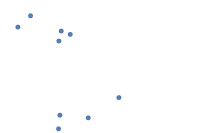

In [11]:
# Dissolving by the address to create the 235 rows of the unique polling location addresses

#dissolved_polling_locations = dissolve_boundaries(polling_locations_fl, output_name="Dissolve_Polling_Locations", dissolve_fields = ["FULLADD"], gis=agol)
dissolved_polling_locations = agol.content.get('c503d5e283234ab2ac178dca153440b1') #The feature layer of the dissolved polling locations
dissolved_polling_locations

In [12]:
dissolved_polling_locations_sdf = dissolved_polling_locations.layers[0].query().sdf
dissolved_polling_locations_sdf

OBJECTID                                            FULLADD  Count_  \
0           1                               1 BARNARD DR, LOT 3B       3   
1           2                                      1 PANTHER WAY       5   
2           3                                       1 PIRATES CV       2   
3           4                                   1 WEST TRIBAL RD       5   
4           5                            10050 AVENIDA MAGNIFICA       1   
..        ...                                                ...     ...   
231       232                                    9711 OVIEDO WAY       1   
232       233                                    9730 HOPKINS DR       3   
233       234                                    9750 GALVIN AVE       1   
234       235                                       9841 VINE ST       3   
235       236  Mail or drop-off your voted mail ballot at a d...       1   

     AnalysisArea SHAPE  
0               0  None  
1               0  None  
2               0  None  
3               0  None  
4               0  None  
..            ...   ...  
231             0  None  
232             0  None  
233             0  None  
234             0  None  
235             0  None  

[236 rows x 5 columns]

In [13]:
dissolved_polling_locations_sdf = dissolved_polling_locations_sdf[:235] #To remove the invalid address as we have done before
dissolved_polling_locations_sdf

OBJECTID                  FULLADD  Count_  AnalysisArea SHAPE
0           1     1 BARNARD DR, LOT 3B       3             0  None
1           2            1 PANTHER WAY       5             0  None
2           3             1 PIRATES CV       2             0  None
3           4         1 WEST TRIBAL RD       5             0  None
4           5  10050 AVENIDA MAGNIFICA       1             0  None
..        ...                      ...     ...           ...   ...
230       231             9353 PIKE RD       2             0  None
231       232          9711 OVIEDO WAY       1             0  None
232       233          9730 HOPKINS DR       3             0  None
233       234          9750 GALVIN AVE       1             0  None
234       235             9841 VINE ST       3             0  None

[235 rows x 5 columns]

We have cleaned and dissolved the polling locations data by the address and have gotten 235 polling locations in San Diego County. This layer will be the layer used for our future calculations of the 'Candidate Points' for our Location-Allocation task.

### Precincts Dataset

In [14]:
# Precincts layer in spatial dataframe preview
precincts_fl = election_polls_and_precincts.layers[1]
precincts_sdf = precincts_fl.query().sdf
display(precincts_sdf.head())
print(precincts_sdf.shape)

print('The number of total precincts before cleaning: {0}'.format(len(precincts_sdf)))

OBJECTID    CONS  COUNT_   EID   BT         CONSNAME  RV_TOTALS  PVBM  \
0         1  105000       8  4182  651  RANCHO BERNARDO       3978  3385   
1         2  105010       3  4182  655  RANCHO BERNARDO       1194  1004   
2         3  105160      19  4182  671  RANCHO BERNARDO       8361  6862   
3         4  105200       2  4182  656  RANCHO BERNARDO        544   447   
4         5  105800       1  4182  669  RANCHO BERNARDO        661   535   

   NET_RVS  PRECINCTID             NAME            COUNTY  POLLINGID  \
0      593      105000  RANCHO BERNARDO  SAN DIEGO COUNTY      10072   
1      190      105010  RANCHO BERNARDO  SAN DIEGO COUNTY      10072   
2     1499      105160  RANCHO BERNARDO  SAN DIEGO COUNTY       2077   
3       97      105200  RANCHO BERNARDO  SAN DIEGO COUNTY        321   
4      126      105800  RANCHO BERNARDO  SAN DIEGO COUNTY        321   

  LASTUPDATE LASTEDITOR  SEQ   Shape__Area  Shape__Length  \
0 2020-09-22               1  3.201980e+07   26061.889313   
1 2020-09-22               2  2.068241e+07   30993.473266   
2 2020-09-22               3  7.091067e+07   39110.791951   
3 2020-09-22               4  3.203414e+06    8281.035032   
4 2020-09-22               5  8.246126e+06   12385.301190   

                                               SHAPE  
0  {"rings": [[[6316995.00007251, 1961191.0011585...  
1  {"rings": [[[6312820.00054851, 1963626.9998954...  
2  {"rings": [[[6308159.99969792, 1952943.9930462...  
3  {"rings": [[[6314186.49978401, 1951195.7494955...  
4  {"rings": [[[6311146.7758766, 1955409.45104183...

(1153, 19)
The number of total precincts before cleaning: 1153


As you can see, there are 1,153 rows in the precincts dataset. We only want to see 572 since every in-person polling station in the last dataset was tied to only 572 precincts. We'll be cleaning the precinct dataset below to try to match this number. 

### Cleaning Precincts Dataset to Only Include In-Person Voting Precincts

In [15]:
#We looked into the Vote-by-mail precincts and dropped them because it is not relevant to our analysis
vote_by_mail = ['VISTA-VBM', 'UNINCORPORATED-VBM', 'ENCINITAS-VBM', 'CARLSBAD-VBM',
       'OCEANSIDE-VBM', 'SAN MARCOS-VBM', 'ESCONDIDO-VBM', 'DEL MAR-VBM',
       'SAN DIEGO-VBM', 'EL CAJON-VBM', 'SANTEE-VBM',
       'IMPERIAL BEACH-VBM', 'NATIONAL CITY-VBM', 'CHULA VISTA-VBM',
       'POWAY-VBM', 'CORONADO-VBM', 'LA MESA-VBM']

def in_vbm(x):
    '''
    Helper function that cleans off the Vote-by-mail precincts
    '''
    if x in vote_by_mail:
        return x

precincts_sdf['CONSNAME'].apply(in_vbm).dropna().index
precincts_dropped_vbm_sdf = precincts_sdf.drop(index = precincts_sdf['CONSNAME'].apply(in_vbm).dropna().index)

In [16]:
display(precincts_dropped_vbm_sdf.head())
print('\nThe number of precincts for the 2020 Election in San Diego county is: {0}'.format(precincts_dropped_vbm_sdf.shape[0]))

OBJECTID    CONS  COUNT_   EID   BT         CONSNAME  RV_TOTALS  PVBM  \
0         1  105000       8  4182  651  RANCHO BERNARDO       3978  3385   
1         2  105010       3  4182  655  RANCHO BERNARDO       1194  1004   
2         3  105160      19  4182  671  RANCHO BERNARDO       8361  6862   
3         4  105200       2  4182  656  RANCHO BERNARDO        544   447   
4         5  105800       1  4182  669  RANCHO BERNARDO        661   535   

   NET_RVS  PRECINCTID             NAME            COUNTY  POLLINGID  \
0      593      105000  RANCHO BERNARDO  SAN DIEGO COUNTY      10072   
1      190      105010  RANCHO BERNARDO  SAN DIEGO COUNTY      10072   
2     1499      105160  RANCHO BERNARDO  SAN DIEGO COUNTY       2077   
3       97      105200  RANCHO BERNARDO  SAN DIEGO COUNTY        321   
4      126      105800  RANCHO BERNARDO  SAN DIEGO COUNTY        321   

  LASTUPDATE LASTEDITOR  SEQ   Shape__Area  Shape__Length  \
0 2020-09-22               1  3.201980e+07   26061.889313   
1 2020-09-22               2  2.068241e+07   30993.473266   
2 2020-09-22               3  7.091067e+07   39110.791951   
3 2020-09-22               4  3.203414e+06    8281.035032   
4 2020-09-22               5  8.246126e+06   12385.301190   

                                               SHAPE  
0  {"rings": [[[6316995.00007251, 1961191.0011585...  
1  {"rings": [[[6312820.00054851, 1963626.9998954...  
2  {"rings": [[[6308159.99969792, 1952943.9930462...  
3  {"rings": [[[6314186.49978401, 1951195.7494955...  
4  {"rings": [[[6311146.7758766, 1955409.45104183...


The number of precincts for the 2020 Election in San Diego county is: 572


The number of precincts also matches the number of precincts assigned to a polling location. The work for this can be seen in the section "Polling Locations Dataset". It matches after we got rid of precincts with 0 registered voters and precincts that were designated vote by mail.

In [17]:
# Looking at how many unique precincts ID are in the dataset
precincts_dropped_vbm_sdf.groupby('POLLINGID').sum()

OBJECTID     CONS  COUNT_    EID    BT  RV_TOTALS  PVBM  NET_RVS  \
POLLINGID                                                                     
26             1915  2001650      34  16728  3149       9834  7399     2435   
31               38   126110      28   4182   696       8053  6454     1599   
50              929   971920      26   8364  1505       9040  6860     2180   
147             166   403520      16   4182   137       7957  6121     1836   
177             176   482920      21  12546  2071       8185  6227     1958   
...             ...      ...     ...    ...   ...        ...   ...      ...   
10151           836  1635750      19  16728   393       7808  6227     1581   
10152           532   541500      40   4182   354       1261  1013      248   
10153            88   238800      15   4182   698       8312  6273     2039   
10155           215   560600      31   8364  1532       9807  6474     3333   
10158            41   130020      21   4182   647       8735  6625     2110   

           PRECINCTID   SEQ   Shape__Area  Shape__Length  
POLLINGID                                                 
26            2001650  1915  6.652996e+07   80662.276798  
31             126110    38  1.011702e+08   52748.220971  
50             971920   929  6.244627e+07   79181.814709  
147            403520   166  8.671587e+07   48152.336479  
177            482920   176  1.827236e+08  119486.978982  
...               ...   ...           ...            ...  
10151         1635750   836  1.267959e+08  117044.322331  
10152          541500   532  1.108346e+10  673895.187916  
10153          238800    88  3.308030e+07   38557.225766  
10155          560600   215  7.560689e+07   57851.337152  
10158          130020    41  1.466379e+08   68171.032008  

[235 rows x 12 columns]

In [18]:
unique_precincts_count = precincts_dropped_vbm_sdf.groupby('POLLINGID').sum().shape[0]
print('\nThe number of unique in-person polling stations IDs the 2020 Election in San Diego county is: {0}'.format(unique_precincts_count))


The number of unique in-person polling stations IDs the 2020 Election in San Diego county is: 235


The number of in-person polling staion IDs also matches the number of in-person polling stations. This is a good sanity check for both of our precinct and polling location datasets. 

In [19]:
#Calculate the rate of non-vbm voters / total registered voters
precincts_dropped_vbm_sdf["rate"] = precincts_dropped_vbm_sdf["NET_RVS"]/precincts_dropped_vbm_sdf["RV_TOTALS"]
precincts_dropped_vbm_sdf["vbm_rate"] = precincts_dropped_vbm_sdf["PVBM"]/precincts_dropped_vbm_sdf["RV_TOTALS"]

The 'rate' column specifies the ratio of registered voters that are not registered as a vote-by-mail voter for the precinct. The 'vbm_rate' column is the opposite, it specifies the ratio of permanent voting-by-mail registered voters for the precinct. These 'rate' column in going to be useful for our Location-Allocation task because it will be specified as the 'weight' for our 'Demand Points'. We created a new feature layer with this to help us with filtered demand points. 

This is the feature layer of the polygons of filtered precinct boundaries with the new rates values added


<Item title:"Precincts with Rates" type:Feature Layer Collection owner:rherlim_dsc170fa20>
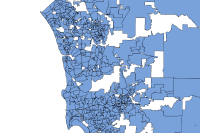

In [20]:
# Convert the new SEDF with the rates columns to a feature layer

# precincts_dropped_vbm_sdf.spatial.to_featurelayer('Precincts with Rates', gis=agol, tags = 'elections')
precincts_w_rate_fl = agol.content.get('90cbd45c727f4d8ab5b02c5413273077')
print('This is the feature layer of the polygons of filtered precinct boundaries with the new rates values added')
precincts_w_rate_fl

In [21]:
#Displaying the top 5 precincts with the highest rate of in-person voting 
precincts_dropped_vbm_sdf.sort_values('rate', ascending=False).head()

OBJECTID    CONS  COUNT_   EID   BT      CONSNAME  RV_TOTALS  PVBM  \
33         34  120040       9  4182  236  UNIVERSITY N       1613  1039   
140       141  370200      11  4182  582  CHOLLAS PARK       3527  2275   
138       139  370000       3  4182  592  CHOLLAS PARK       1952  1262   
125       126  320310      13  4182  584        HARBOR       7551  4894   
107       108  280500       4  4182  760     MONTEZUMA       1232   800   

     NET_RVS  PRECINCTID  ...            COUNTY POLLINGID  LASTUPDATE  \
33       574      120040  ...  SAN DIEGO COUNTY     10124  2020-09-22   
140     1252      370200  ...  SAN DIEGO COUNTY     10023  2020-09-22   
138      690      370000  ...  SAN DIEGO COUNTY     10074  2020-09-22   
125     2657      320310  ...  SAN DIEGO COUNTY     10041  2020-09-22   
107      432      280500  ...  SAN DIEGO COUNTY     10155  2020-09-22   

    LASTEDITOR  SEQ   Shape__Area  Shape__Length  \
33               34  3.228345e+07   25254.950293   
140             141  3.201508e+07   35115.499029   
138             139  1.406376e+07   18509.626785   
125             126  6.252043e+07   43305.660087   
107             108  2.131398e+07   19861.326087   

                                                 SHAPE      rate  vbm_rate  
33   {"rings": [[[6261521.16285767, 1903960.6366168...  0.355859  0.644141  
140  {"rings": [[[6304064.50034301, 1832344.9999927...  0.354976  0.645024  
138  {"rings": [[[6299315.93995826, 1842420.3203932...  0.353484  0.646516  
125  {"rings": [[[6293363.00009251, 1839881.0000125...  0.351874  0.648126  
107  {"rings": [[[6307540.99995168, 1863000.0006905...  0.350649  0.649351  

[5 rows x 21 columns]

### Existing Land Use Dataset

### Exploring and Cleaning the Existing Land Use Layer

The Existing Land Use Layer consists of over 1 million rows of data. It's a highly granular layer, as seen on the picture below, and our notebooks could not handle loading in and filtering all of that data. So intead, we cleaned this layer directly in ArcGIS Online because loading the Land Use FL was killing our kernel. 

We'll filter and clean the land use dataset after doing some EDA on it. We want to see commonly used layers instead of filtering only using our prior research with article data. Please refer to the next section titled "Descriptive statistics for the data" to see our reasoning behind why we filtered the data the way that we did. 

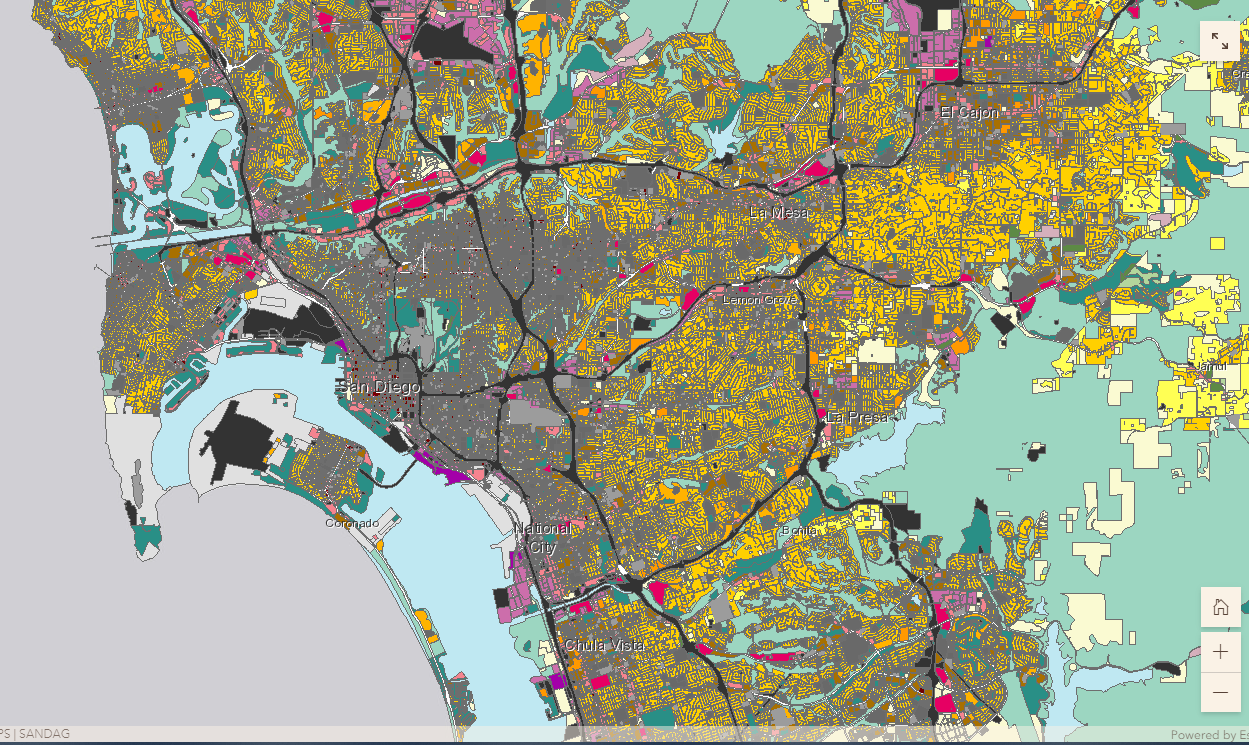

Dynamic Map of the Land Use Layers (with a screenshot in case it doesn't load), with different colors signifying different land use. Refer to the layer description link located in section 5 titled "Data sources" to find the legend.

# Descriptive statistics for the data (EDA)<a class="anchor" id="eda"></a>

### Q: What are the general statistics of registered voters amongst the precincts? 

In [21]:
precincts_dropped_vbm_sdf['RV_TOTALS'].describe()

count     572.000000
mean     3189.381119
std      2667.145403
min       251.000000
25%       994.250000
50%      2289.500000
75%      4923.500000
max      9952.000000
Name: RV_TOTALS, dtype: float64

In [22]:
total_voters = precincts_dropped_vbm_sdf['RV_TOTALS'].sum()
total_vbm_voters = precincts_dropped_vbm_sdf['PVBM'].sum()
total_non_vbm_voters =  precincts_dropped_vbm_sdf['NET_RVS'].sum()

print("In total there are {0} registered voters in San Diego county".format(total_voters))
print("In total there are {0} registered voters who permanently vote by mail in San Diego county".format(total_vbm_voters))
print("In total there are {0} registered voters by who don't vote by mail in San Diego county".format(total_non_vbm_voters))

In total there are 1824326 registered voters in San Diego county
In total there are 1399270 registered voters who permanently vote by mail in San Diego county
In total there are 425056 registered voters by who don't vote by mail in San Diego county


### Q: Can we create a heatmap that visualizes the rate of permanent in-person voters in each precinct? 

<Item title:"Heat Map VBM vs NVBM" type:Web Map owner:rherlim_dsc170fa20>
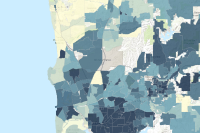

In [74]:
#Here is a heatmap of registered voters for the precincts in San Diego County
heat_map_precincts = agol.content.get('4bf9d72e5ee44980886ac74901cd1121')
heat_map_precincts

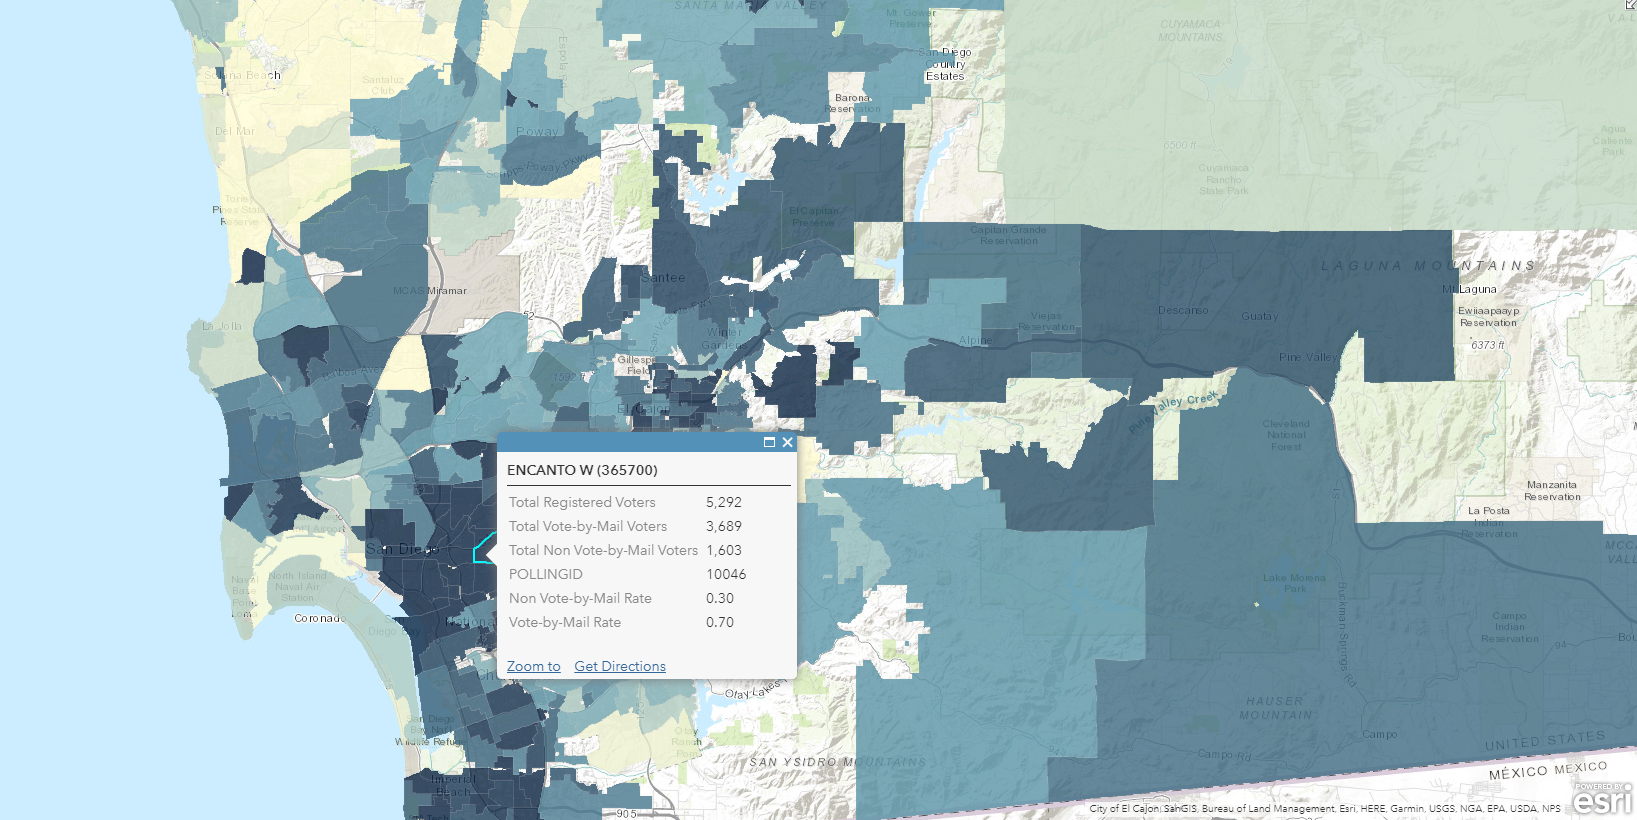

We created this heatmap to visualize the distribution of registered voters for each precinct to get a better idea of the precincts with high/low registered voter rates. We can see that San Diego county has generally a low non vote-by-mail rate.

### Q: In what precincts are the current polling locations located?

In [156]:
# load the overlay layer built on arcgis map viewer

overlay = agol.content.get('3539ec0205e646a1bf44b4bfe8487135')
overlay_sdf = overlay.layers[0].query().sdf
overlay_sdf.head(3)

OBJECTID  Join_Count  TARGET_FID  POLL_ZIP POLL_TYPE  USED    CONS_NAME  \
0         1           1           1     92154       SCH     1         OTAY   
1         2           1           2     91911       SCH     2  CHULA VISTA   
2         3           1           3     91911       SCH     1  CHULA VISTA   

       CONS  SEQ  LOC_ID  ...  PRECINCTID       NAME_1            COUNTY  \
0  390410.0  156      95  ...      390410         OTAY  SAN DIEGO COUNTY   
1  529810.0  512     233  ...      529900  CHULA VISTA  SAN DIEGO COUNTY   
2  529520.0  511     205  ...      529520  CHULA VISTA  SAN DIEGO COUNTY   

  POLLINGID_1 LASTUPDATE_1  LASTEDITOR_1 SEQ_1   Shape__Area Shape__Length  \
0        3406   2020-09-22                 156  2.819900e+07  25593.922760   
1        1844   2020-09-22                 513  4.761235e+07  37301.240517   
2        1947   2020-09-22                 511  4.425314e+07  31952.477274   

                                               SHAPE  
0  {"x": 6315511.083748966, "y": 1793564.17991672...  
1  {"x": 6304255.891036302, "y": 1802164.87925073...  
2  {"x": 6313155.43294847, "y": 1804478.318849563...  

[3 rows x 49 columns]

In [162]:
precincts_w_stations = overlay_sdf['PRECINCTID'].unique()
print(precincts_w_stations)

[390410 529900 529520 525110 531890 525100 532650 525250 532570 528960
 501720 515600 516500 307500 360000 361100 500210 306400 320000 370110
 316500 571920 500010 261400 240400 558500 296600 255000 255220 492800
 245220 558350 484910 274110 180010 211010 175080 190110 150410 472610
 557410 471120 479150 160000 150000 171010 553110 154800 467500 126110
 552010 125260 479320 569120 120030 548780 135010 130160 130030 111090
 135000 115050 135100 110332 115130 461600 461900 110010 110270 461700
 416600 461190 106500 436350 435010 106350 413430 546330 412400 412750
 408520 543610 459330 432970 408010 408110 457700 408050 432240 457400
 454560 454510 432080 425140 403520 422940 404090 423410 403840 403410
 403450 565400 421400 419790 419540 444680 527700 408620 111000 110900
 412010 404310 429510 270100 532940 466230 531000 110000 135080 220100
 272600 106340 546310 403440 404640 455000 445940 441600 385650 531960
 499540 181710 466240 424700 403460 404060 554530 531130 481200 200700
 49968

In [165]:
print(len(precincts_w_stations))

234


### Q: What is the average rate of non-vbm voters in the locations for official 2020 polling locations.

In [170]:
pd.options.mode.chained_assignment = None  

official_precinct = precincts_sdf[precincts_sdf['PRECINCTID'].isin(precincts_w_stations) == True]
official_precinct['rate'] = official_precinct['NET_RVS']/official_precinct['RV_TOTALS']
official_precinct['rate'].describe()

count    234.000000
mean       0.231956
std        0.038525
min        0.053388
25%        0.211794
50%        0.233892
75%        0.251711
max        0.355859
Name: rate, dtype: float64

What's interesting is that some polling locations were located in VBM precincts. Our filtered precinct feature layer will not take into account VBM precincts, so we expect polling station locations to differ.

### Q: Where are polling places most often distributed?

In order to answer this question, we chose to perform a spatial join between the land use layer and the polling station location layer. However, we were not able to run a spatial join between the full Land Use Layer and the polling station location layer on ArcGIS Online Mapviewer because the Land Use layer was too large. So instead, we got a sample area in downtown San Diego where many polling locations were located, and we performed a spatial join between land use and the polling locations to find which areas we want to put our polling locations in. We found that most polling locations were located in areas marked by: Education, Recreation, and Institution. 

<Item title:"Polling_Locations_w_Land_Use" type:Feature Layer Collection owner:rherlim_dsc170fa20>
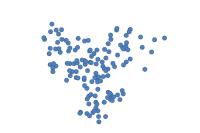

In [26]:
#Importing the sampled joined polling locations and land use layer and converting into SEDF
locations_w_land_use = agol.content.get('132a6b437cdc4b18a47d4cd8c43c9d52')
locations_w_land_use_sdf = locations_w_land_use.layers[0].query().sdf
locations_w_land_use

We sampled an area of downtown San Diego to take a closer look on what is happening in the Land Use Layer, then joined the layer with the existing polling locations to get a better understanding of how the land use layer can provide additional data and information about polling locations. All of this was done with ArcGIS Online Mapviewer since the Land Use layer would not load onto our notebook. 

In [27]:
print('The shape of this sample DataFrame')
print(locations_w_land_use_sdf.shape)
locations_w_land_use_sdf.head(3)

The shape of this sample DataFrame
(278, 34)


OBJECTID  Join_Count  TARGET_FID  POLL_ZIP POLL_TYPE  USED    CONS_NAME  \
0         1           1           1     92154       SCH     1         OTAY   
1         2           1           2     91911       SCH     2  CHULA VISTA   
2         3           1           3     91911       SCH     1  CHULA VISTA   

       CONS  SEQ  LOC_ID  ...  CONTACT PHONE  EMAIL  \
0  390410.0  156      95  ...     None  None   None   
1  529810.0  512     233  ...     None  None   None   
2  529520.0  511     205  ...     None  None   None   

                                          SMPLBALLOT  \
0  https://www.sdvote.com/content/rov/en/viewsamp...   
1  https://www.sdvote.com/content/rov/en/viewsamp...   
2  https://www.sdvote.com/content/rov/en/viewsamp...   

                                             CHK_REG  LASTUPDATE LASTEDITOR  \
0  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
1  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
2  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   

     lu    Landuse                                              SHAPE  
0  6806  Education  {"x": 6315511.083748966, "y": 1793564.17991672...  
1  6806  Education  {"x": 6304255.891036302, "y": 1802164.87925073...  
2  6806  Education  {"x": 6313155.43294847, "y": 1804478.318849563...  

[3 rows x 34 columns]

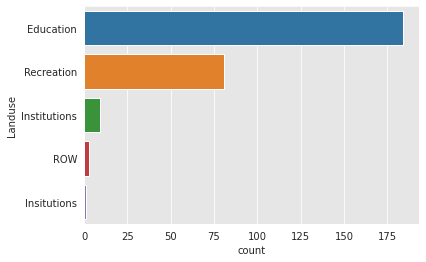

In [28]:
#Visualizing the most common land use categories for the polling locations
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.countplot(y="Landuse", data=locations_w_land_use_sdf)

For existing polling locations, education, recreation, and institutions categories are the most common, therefore we chose these 3 categories as our 'relevant categories' later on to filter out the existing land use feature layer for our candidate locations.

In [29]:
# Filtering out only the land use categories that are relevant
land_use = ['Education', 'Recreation', 'Institutions']
locations_w_land_use_sdf = locations_w_land_use_sdf[locations_w_land_use_sdf['Landuse'].isin(land_use)]
locations_w_land_use_sdf

OBJECTID  Join_Count  TARGET_FID  POLL_ZIP POLL_TYPE    USED  \
0           1           1           1     92154       SCH       1   
1           2           1           2     91911       SCH       2   
2           3           1           3     91911       SCH       1   
3           4           1           4     91910       SCH       2   
4           5           1           5     91913       SCH       1   
..        ...         ...         ...       ...       ...     ...   
273       274           1         274     92021       REC       6   
274       275           1         275     92020       SCH       7   
275       276           1         276     92021       REC       6   
276       277           1         277     92020       SCH       7   
277       278           1         278     92123       ROV  999999   

       CONS_NAME      CONS     SEQ  LOC_ID  ...  CONTACT PHONE  EMAIL  \
0           OTAY  390410.0     156      95  ...     None  None   None   
1    CHULA VISTA  529810.0     512     233  ...     None  None   None   
2    CHULA VISTA  529520.0     511     205  ...     None  None   None   
3    CHULA VISTA  525110.0     496     198  ...     None  None   None   
4    CHULA VISTA  531890.0     523     212  ...     None  None   None   
..           ...       ...     ...     ...  ...      ...   ...    ...   
273     EL CAJON  477210.0     448     177  ...     None  None   None   
274     EL CAJON  476600.0     446     178  ...     None  None   None   
275     EL CAJON  477400.0     449     177  ...     None  None   None   
276     EL CAJON  476610.0     447     178  ...     None  None   None   
277         None       NaN  999999     999  ...     None  None   None   

                                            SMPLBALLOT  \
0    https://www.sdvote.com/content/rov/en/viewsamp...   
1    https://www.sdvote.com/content/rov/en/viewsamp...   
2    https://www.sdvote.com/content/rov/en/viewsamp...   
3    https://www.sdvote.com/content/rov/en/viewsamp...   
4    https://www.sdvote.com/content/rov/en/viewsamp...   
..                                                 ...   
273  https://www.sdvote.com/content/rov/en/viewsamp...   
274  https://www.sdvote.com/content/rov/en/viewsamp...   
275  https://www.sdvote.com/content/rov/en/viewsamp...   
276  https://www.sdvote.com/content/rov/en/viewsamp...   
277  https://www.sdvote.com/content/rov/en/viewsamp...   

                                               CHK_REG  LASTUPDATE LASTEDITOR  \
0    https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
1    https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
2    https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
3    https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
4    https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
..                                                 ...         ...        ...   
273  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
274  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
275  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
276  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   
277  https://www.sdvote.com/content/rov/en/Registra...  2020-09-22       None   

       lu       Landuse                                              SHAPE  
0    6806     Education  {"x": 6315511.083748966, "y": 1793564.17991672...  
1    6806     Education  {"x": 6304255.891036302, "y": 1802164.87925073...  
2    6806     Education  {"x": 6313155.43294847, "y": 1804478.318849563...  
3    6806     Education  {"x": 6302046.047358885, "y": 1808767.37884098...  
4    6806     Education  {"x": 6335599.43891339, "y": 1810993.571238979...  
..    ...           ...                                                ...  
273  7601    Recreation  {"x": 6348554.11411947, "y": 1871385.437003567...  
274  6805    

### Q: Where are polling places most often distributed? Are there more specific locations that we can filter by?

We only wanted to look at the polling locations that are located in Recreation, Education, and Institutional categories, however we need to take a more in depth look at what specifically are these buildings. The dataset provides a land use code for the buildings on the column 'lu'.

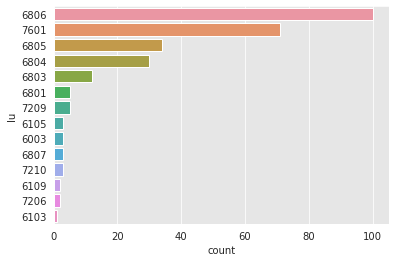

In [30]:
sns.countplot(y="lu", data=locations_w_land_use_sdf, order = locations_w_land_use_sdf['lu'].value_counts().index)

The Land Use Dataset had specific land use definitions that we could filter by so we manually filtered relevant locations. We found that these are the most common land use codes for the existing polling locations. Examples of land use IDs in the chart include: 6806 (Elementary Schools), 7601 (Active Parks), and 6103 (Libraries). We wanted to further reduce the number of polygons since the layer was still relatively large. We also manually viewed each code and personally determined whether these codes would be relevant for hosting polling locations. For a more in depth look at these codes please refer to [SANDAG's Land Use Codes](https://www.sandag.org/resources/maps_and_gis/gis_downloads/downloads/codes/Land_Use_Definitions.html). To check out the codes that we kept, please refer to the section right below this one. 

### Cleaning Land Use Layer and Preparation for Candidate Locations

We wanted to edit the land use layer to only include areas in the above categories so we did this in arcgis mapviewer. (Existing Land Use Filtered San Diego County url: https://ucsdonline.maps.arcgis.com/home/item.html?id=e74f636c8d86422c91a2ae05283137fc). This gave us 2,578 possible areas that we could put our polling locations. 

<Item title:"Existing Land Use Filtered San Diego County" type:Feature Layer Collection owner:rherlim_dsc170fa20>
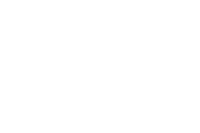

In [31]:
#The filtered land use layer
filtered_land_use_fl = agol.content.get('e74f636c8d86422c91a2ae05283137fc')
filtered_land_use_fl

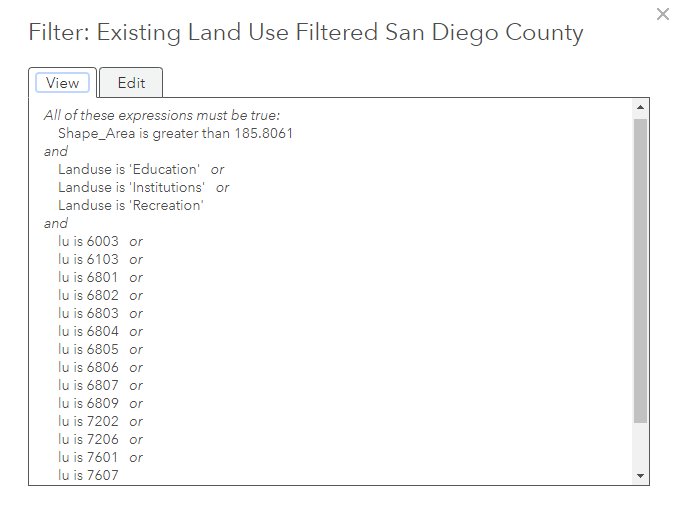

Afterwards we wanted to spatial join the parcels that are greater than 2000 square feet (Layer name: Parcels Greater than 2000) to this new filtered land use to get a list of available buildings for candidates, however, we were not able to spatial join, and instead encountered an error each time we tried to spatial join with the parcel layer. This is because it was way too large. Due to the sheer size of this dataset, we decided to not use it since our local machines could not handle cleaning it. 

Instead, we took land use areas that were greater than 2000 square feet in the layer specified above. Since this layer is in ESPG:3857, that means the unit of measure is meters. We converted 2000 square feet to square meters and filtered locations that were larger than that.

After taking into account the size, we were left with **2576 areas that we could put our polling station**. 

<Item title:"Filtered Land Use Map (Presentation)" type:Web Map owner:rherlim_dsc170fa20>
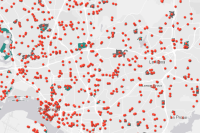

In [23]:
#The webmap version of the filtered land use for visualization
landuse_webmap = agol.content.get('fde0f54f26ee45b897b0c5dc8ca1357a') #Web Map Format
landuse_webmap

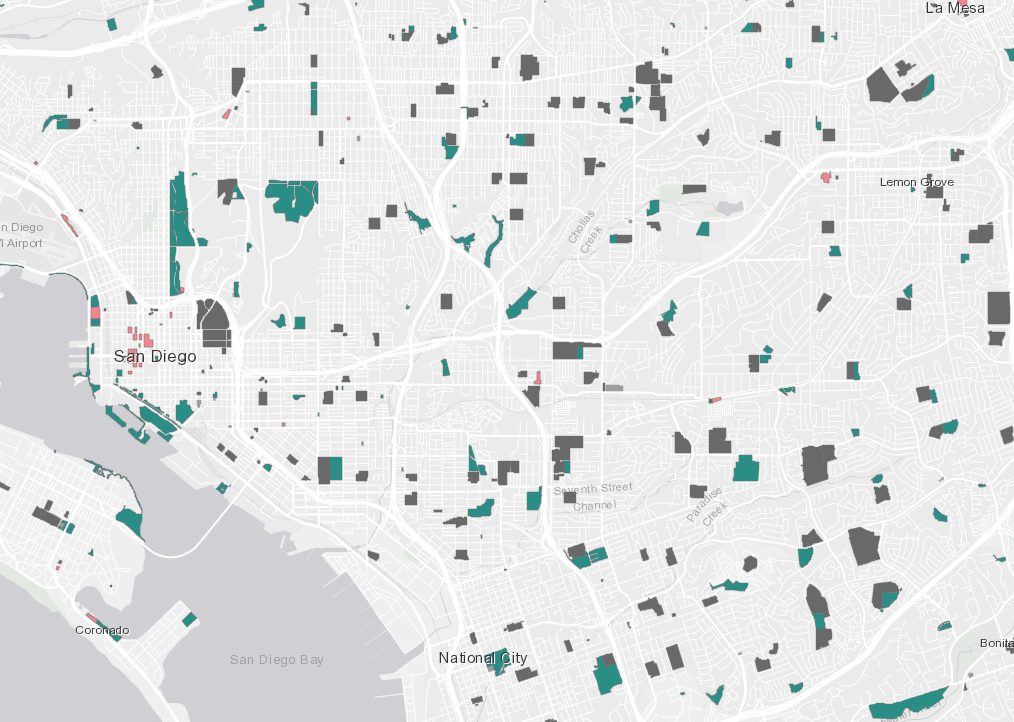
Screenshot of the webmap of the filtered polygons from our Webmap. These are the locations that met our filtering requirements.

Above, you can see a screenshot of the map that contains the filtered areas that we can put our polling station. We'll include a webmap below to aid our analysis. 

# Analysis<a class="anchor" id="analysis"></a>

## Diagram of Analysis

For the analysis task as mentioned before we are going to create a location-allocation model that maximizes voter attendance. To do this these are the steps we are going to perform:

- __Identify the Candidate Points__. Candidate points are the possible locations in the filtered locations from the 'Existing Land Use' layer that can be used as a new polling location. This will allow us to see how many potential locations can be used as a polling location. To do this we will be calculating centroid points for each polygon in the filtered Existing Land Use layer.

- __Identify Demand Points__. Demand points are the areas that our candidate locations will be allocated/assigned to. In our case the precinct areas of interest (in-person voting only) are our demand points. Since each precinct has to be assigned to a polling location, we will calculate the centroids of each precinct and serve them as our demand points. The candidate locations (land use centroids) will be allocated accordingly to each precinct centroid.

- __Assign Weights to demand points__. Weights will determine how our location-allocation task is calculated, they will determine how the candidate locations will be chosen and how the demand points (precinct centroids) will be assigned to the chosen locations (our new polling locations). For starters, we chose to use the ‘Non-vote-by-mail Rate’ of the precinct to calculate the weight of each precinct. This is a simple weight factor that will allow us to allocate the new location such that it maximizes the in-person voter attendance.
 
- __Perform the location-allocation task__. Some measures to keep in mind are that we are using Drive Time as a measure and we set a maximum drive time of 10 minutes to the locations, this prevents the chosen location from being too far from its allocated precinct. We are also not specifying a ‘Required Facilities Layer’ (point layer of already existing locations that is excluded from the analysis to prevent duplicates), we are fine if the location-allocation assigns an already existing polling location as one of the chosen locations because we are simply trying to see if we are able to choose polling locations at a more optimized way, backed with GIS technology, and not trying to come up with all new locations, if our location-allocation model chooses an already existing polling location that means that the model is performing appropriately and choosing good locations.

- __Geoenriching__ to see how different our new locations are compared to the existing polling locations in terms of race, income, or age demographics. These are just the basic exploration we will do with our data, with more time and research we will do a more in-depth analysis of how our new polling locations differ from the existing locations.

** As we go through this section, the code will be explained through markdown comments and map visualizations. **

### Location-Allocation Pipeline

NOTE: Much of the work was done on ArcGIS Online Mapviewer because it was easier to visualize and because the large size of the Land Use Layer made it hard to work on the Jupyter Notebook. Nonetheless, we will detail each step we took on ArcGIS Online so we can explain our thought process. 

#### Identify Candidate Points (Choosing the relevant polling locations)

First, we need to get the '__candidate polling locations__' - these are the potential places to open a new polling location.

Our candidate locations should:

- Have similar qualities to existing polling locations
- Buildings have to have an area of > 2000sq ft to follow COVID regulations

To do this we will need to calculate the centroids for each of the polygon in the filtered land use layer mentioned in the previous steps. We also made sure to use the whole layer by unchecking the 'User current map extent' box.

<Item title:"Existing Land Use Filtered San Diego County" type:Feature Layer Collection owner:rherlim_dsc170fa20>
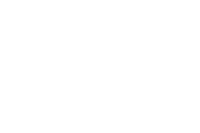

In [171]:
#The layer we are generating the centroids from
filtered_land_use_fl

How we generated centroids on ArcGIS Online Mapviewer:

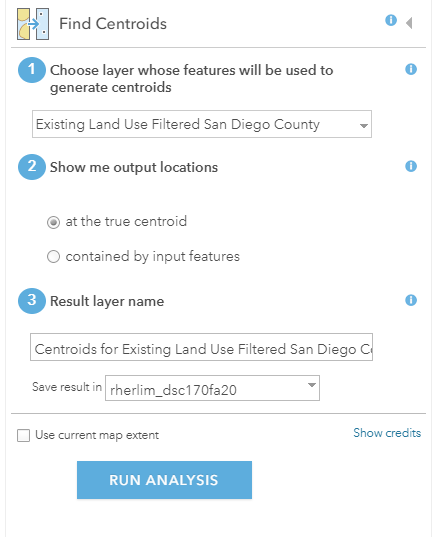

<Item title:"Centroids for Filtered Existing Land Use (Candidate Points)" type:Feature Layer Collection owner:rherlim_dsc170fa20>
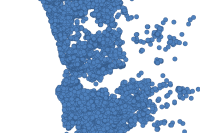

In [83]:
#The calculated centroids for the candidate locations
existing_land_use_filtered_centroids = agol.content.get('de063036e56643e8a9f1d8c38672c54d')
existing_land_use_filtered_centroids

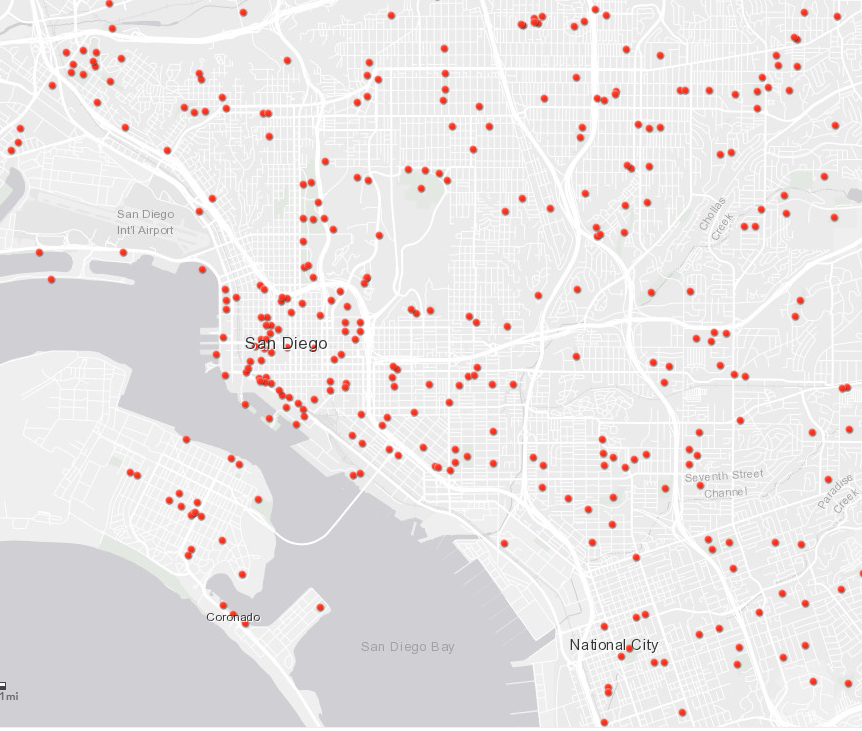
We went from having polygons, into only having a point layer of the centroids. This will serve as the candidate points layer for our location-allocation task.

In [25]:
#Visualizing the polygons of the filtered land use locations, and the centroids that we calculated on a Web Map
WebMap(landuse_webmap)

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

Visualizing the calculated centroids on top of the filtered land use layer polygons.

#### Identify Demand Points (Preparing the precincts layer)

We now need to get the '__demand points__' - polling locations need to be located to service best the existing population in San Diego county. The demand points are weighted by the rate of non-vbm voters/total registered voters specified as the 'rate' column in the layer's columns. This helps us put polling locations in areas where most people are likely to vote in person. 

<Item title:"Precincts with Rates" type:Feature Layer Collection owner:rherlim_dsc170fa20>
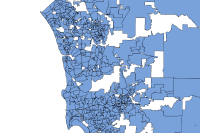

In [85]:
#The precinct layer we are working with
precincts_w_rate_fl

Using the layer of precincts that have been assigned the 'rate' column, we will now calculate the centroid points. The procedure is the same as calculating the centroids for the candidate points that we did above.
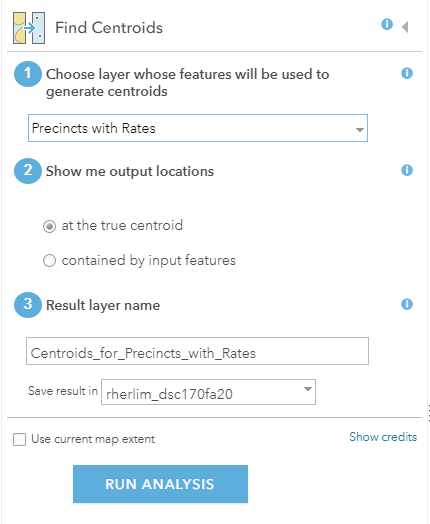

The calculated centroids of the precinct polygons, which will serve as the Demand Points of our Location-Allocation analysis


<Item title:"Centroids_for_Precincts_with_Rates (Demand Points)" type:Feature Layer Collection owner:rherlim_dsc170fa20>
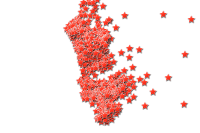

In [86]:
# Getting centroids for filtered precincts layer
precinct_centroids_filtered_fl = agol.content.get('54ed465b2db7413a93d3cd3c93a41a20')
print('The calculated centroids of the precinct polygons, which will serve as the Demand Points of our Location-Allocation analysis')
precinct_centroids_filtered_fl

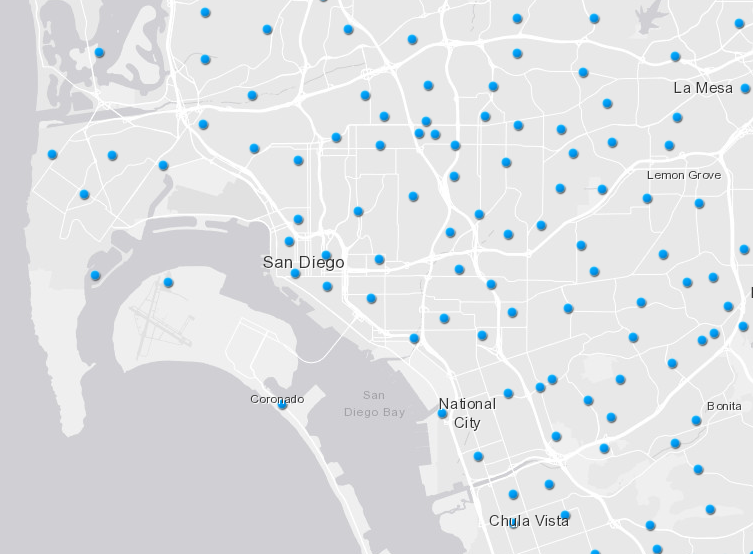
Screenshot of the centroids layer output. This will serve as the demand points layer for our location-allocation task

## Performing the Location-Allocation Analysis<a class="anchor" id="location-allocation"></a>

We will now go through the steps to creating the Location-Allocation pipeline in ArcGIS Online.

1) Get all the required layers: The 'Candidate Points', and 'Demand Points' layers which we specified above.

2) Go to Analysis -> Choose Best Facilties -> Maximize Coverage.

3) Specify these conditions for the Location-Allocation task: 

    1a.) Measure: Driving Time

    1b.) Travel Direction: Demand to Facility

    2a.) Demand Locations Layer: Choose our Demand Points Layer, in this example we chose the 'Centroids_for_Precincts_with_Rates (Demand Points)'

    2b.) Set the 'Amount of demand at each demand location' to the 'rate' variable which is the calculated 'In-person registered voters / Total Registed Voters' for each precinct. This will be the weighting factor of our calculation.

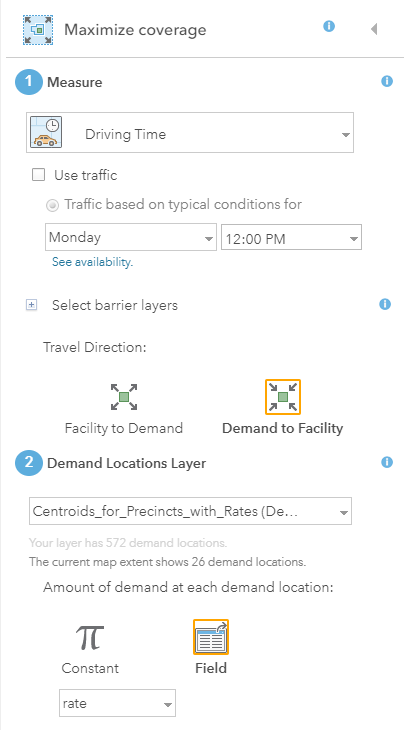

    2c.) Set the 'Maximum Travel Range' to 10 minutes of driving time.(Or any specified time for the use case)

    3.) Leave the Required Facilities as is because we are not comparing to other facilities, we are just trying to see if our new locations are different/better alternatives to current locations.

    4a.) Set Candidate Facilities Layer to the 'Candidate Points' in this case we are using the 'Centroids for Existing Land Use' layer.

    4b.) We then have to specify the Number of Candidates to choose, this value will vary with different subsets of our location of interest, we will simply look at the map and look at how many existing polling locations exist within our subset. In this example subset of 'South San Diego', we count 31 existing polling locations, therefore we want to generate 31 new alternatives. We do not want to create more than what is available right now, however we could change this amount to include more/less depending on which areas we are analyzing.

    5.) Finally, assign a name for this new layer that we created according to the area of interest, in this case we are naming this for the South San Diego region.

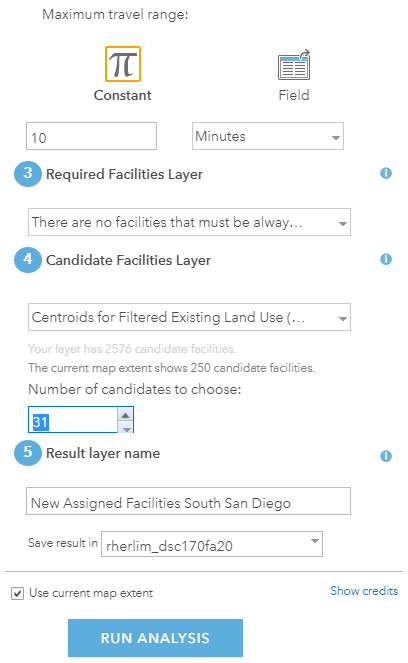

## Location-Allocation Results<a class="anchor" id="loc-results"></a>

Due to the limitations of the number of candidate points we can analyze at one instance of the Location-Allocation function from Network Analysis, we are only able to choose 1000 candidate points at a time. To alleviate this problem, we will be choosing subsets of San Diego County, and will be exploring different major landscapes/cities in San Diego County to perform our analysis. The areas we will be analyzing are: **South San Diego, Center San Diego, La Jolla/UCSD Region, Del Mar/Encinitas Region, North San Diego**

South San Diego Results


<Item title:"Final_Assigned_Locations_South_San_Diego" type:Feature Layer Collection owner:rherlim_dsc170fa20>
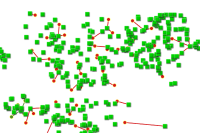

Center San Diego Results


<Item title:"Final_Assigned_Locations_for_Middle_San_Diego" type:Feature Layer Collection owner:rherlim_dsc170fa20>
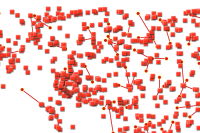

La Jolla/UCSD Region Results


<Item title:"Final_Assigned_Locations_for_La_Jolla_Extended" type:Feature Layer Collection owner:rherlim_dsc170fa20>
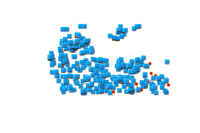

Delmar/Encinitas Region Results


<Item title:"Final_Assigned_Locations_for_Middle_North_of_San_Diego" type:Feature Layer Collection owner:rherlim_dsc170fa20>
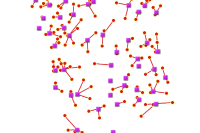

North San Diego Results


<Item title:"Final_Assigned_Locations_for_North_San_Diego" type:Feature Layer Collection owner:rherlim_dsc170fa20>
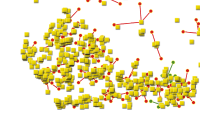

In [87]:
south_sd = agol.content.get('f91673b08ca0444095af96dbfb0438ca')
print('South San Diego Results')
display(south_sd)

center_sd = agol.content.get('850ab08d346646df9cdad6eb542b95a4')
print('Center San Diego Results')
display(center_sd)

lajolla_ucsd = agol.content.get('53a53489cd8943fb8e39f22a5b38e701')
print('La Jolla/UCSD Region Results')
display(lajolla_ucsd)

delmar_encinitas = agol.content.get('a7a9871d07454288aa75de956c0f3059')
print('Delmar/Encinitas Region Results')
display(delmar_encinitas)

north_sd = agol.content.get('1f68d426339545c5b382eb2f7c91776a')
print('North San Diego Results')
display(north_sd)

## Geoenrich the new areas with polling locations<a class="anchor" id="geoenrich"></a>
Get things such as: income, race, and age. This will help us decide whether the past polling locations were less accessible to certain demographics than the polling stations that we generated. 

In [29]:
# Importing geoenrichment layers
usa = Country.get('USA')
df = usa.data_collections # check out all of the data collections for the USA

In [30]:
# get the relevant columns from the `Age` data collection
relevant_columns = []
age_columns = []
for i in df.loc['Age']['analysisVariable'].unique():
    if i[4] == 'M':
        if int(i[8:]) > 18:
            relevant_columns.append(i[4:])
            age_columns.append(i[4:])
    else:
        if int(i[7:]) > 18:
            relevant_columns.append(i[4:])
            age_columns.append(i[4:])
            
# get the relevant columns from the race data collection
race_columns = []
for i in df.loc['RaceAndEthnicity']['analysisVariable'].unique():
    relevant_columns.append(i[17:])
    race_columns.append(i[17:])
    
# get the relevant columns from the income data collection
income_columns = []
for i in df.loc['HouseholdsByIncome']['analysisVariable'].unique():
    relevant_columns.append(i[19:])
    income_columns.append(i[19:])

In [31]:
print(relevant_columns)

['MALE20', 'MALE25', 'MALE30', 'MALE35', 'MALE40', 'MALE45', 'MALE50', 'MALE55', 'MALE60', 'MALE65', 'MALE70', 'MALE75', 'MALE80', 'MALE85', 'FEM20', 'FEM25', 'FEM30', 'FEM35', 'FEM40', 'FEM45', 'FEM50', 'FEM55', 'FEM60', 'FEM65', 'FEM70', 'FEM75', 'FEM80', 'FEM85', 'WHITE_CY_P', 'BLACK_CY_P', 'AMERIND_CY_P', 'ASIAN_CY_P', 'PACIFIC_CY_P', 'OTHRACE_CY_P', 'RACE2UP_CY_P', 'HISPPOP_CY_P', 'HINC0_CY_P', 'HINC15_CY_P', 'HINC25_CY_P', 'HINC35_CY_P', 'HINC50_CY_P', 'HINC75_CY_P', 'HINC100_CY_P', 'HINC150_CY_P', 'HINC200_CY_P']


In [33]:
# get a list of old polling locations in the South SD subsection
south_polling_locations = ['455 Sycamore Rd San Diego, CA 92173 San Ysidro ', '425 IMPERIAL BEACH BLVD', '601 ELM AVE', '1885 CORONADO AVE',
                           'Southwest High School, San Diego', '179 Diza RdSan Ysidro, CA 92173', '5353 AIRWAY RD', '3020 CORONADO AVE', 
                           '3250 PALM AVE', '3950 BYRD ST, San Diego, CA 92154', '681 NAPLES ST, Chula Vista, CA 91911', '25 EMERSON ST', '1395 HILLTOP DR',
                           '3554 MAIN ST, San Diego, CA 92113', '715 I ST, Chula Vista, CA 91910', '415 5TH AVE', '555 CLAIRE AVE, Chula Vista, CA 91910', '270 F ST, Chula Vista, CA 91910', 
                           '3724 VALLEY VISTA WAY', '650 OTAY LAKES RD, Chula Vista, CA 91910', '751 OTAY LAKES RD, Chula Vista, CA 91910',
                           '900 OTAY LAKES RD, LOT A, Chula Vista, CA 91910', '1174 E J ST, Chula Vista, CA 91910', '785 E PALOMAR ST, Chula Vista, CA 91911', '1381 E PALOMAR ST, Chula Vista, CA 91911',
                           '1201 SANTA CORA AVE', '1250 OLYMPIC PKWY', 
                           '1650 EXPLORATION FALLS DR', '1120 EASTLAKE PKWY, MAIN ENTRANCE', '2710 OTAY LAKES RD, Chula Vista, CA 91915',
                           '900 DUNCAN RANCH RD']

south_polling_locations_sdf = dissolved_polling_locations_sdf[:0] # initialize an empty sdf
for i in relevant_columns:
    south_polling_locations_sdf[i] = 0
    
# geoenrich them with age, income, and race
for i in south_polling_locations:
    add_stats = enrich(study_areas=[str(i)], data_collections=['Age', 'RaceAndEthnicity', 'HouseholdsByIncome'])[relevant_columns]
    
    for j in add_stats.columns:
        south_polling_locations_sdf.loc[i, j] = add_stats[j][0]
    
south_polling_locations_sdf.head(2)  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OBJECTID FULLADD  Count_  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro        NaN     NaN     NaN   
425 IMPERIAL BEACH BLVD                               NaN     NaN     NaN   

                                                 AnalysisArea SHAPE  MALE20  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro            NaN  None   718.0   
425 IMPERIAL BEACH BLVD                                   NaN  None   568.0   

                                                 MALE25  MALE30  MALE35  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro    752.0   585.0   429.0   
425 IMPERIAL BEACH BLVD                           734.0   622.0   519.0   

                                                 MALE40  ...  HISPPOP_CY_P  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro    371.0  ...         93.85   
425 IMPERIAL BEACH BLVD                           371.0  ...         55.72   

                                                 HINC0_CY_P  HINC15_CY_P  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro         12.1         11.4   
425 IMPERIAL BEACH BLVD                                11.1          9.2   

                                                 HINC25_CY_P  HINC35_CY_P  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro          14.2         19.3   
425 IMPERIAL BEACH BLVD                                 10.1         16.7   

                                                 HINC50_CY_P  HINC75_CY_P  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro          18.8         10.9   
425 IMPERIAL BEACH BLVD                                 20.2         11.7   

                                                 HINC100_CY_P  HINC150_CY_P  \
455 Sycamore Rd San Diego, CA 92173 San Ysidro            8.7           2.5   
425 IMPERIAL BEACH BLVD                                  10.2           6.1   

                                                 HINC200_CY_P  
455 Sycamore Rd San Diego, CA 92173 San Ysidro            2.0  
425 IMPERIAL BEACH BLVD                                   4.7  

[2 rows x 50 columns]

In [191]:
y_columns_age = []

for i in range(20,86, 5):
    y_columns_age.append('Male, ' + str(i))
    
for i in range(20,86, 5):
    y_columns_age.append('Female, ' + str(i))

[(0.0, 30000.0)]

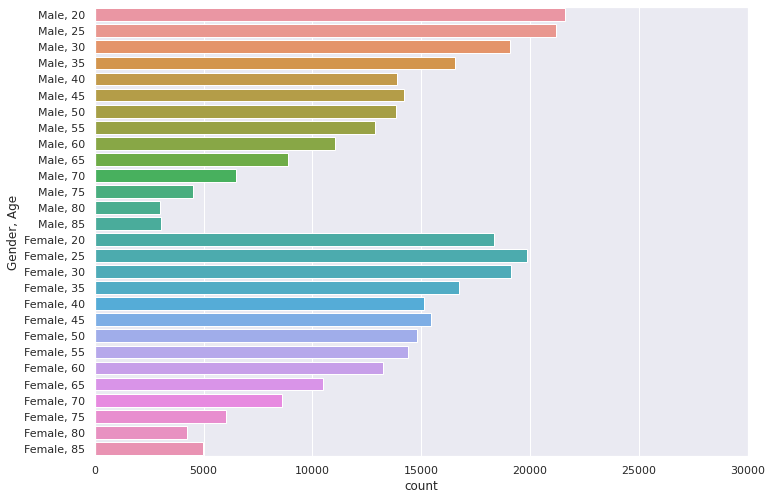

In [200]:
# age count in southern san diego official polling locations

sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.barplot(x=south_polling_locations_sdf[age_columns].sum().values, y=y_columns_age)
ax.set(xlabel='count', ylabel='Gender, Age')
ax.set(xlim=(0, 30000))


[(0.0, 2000.0)]

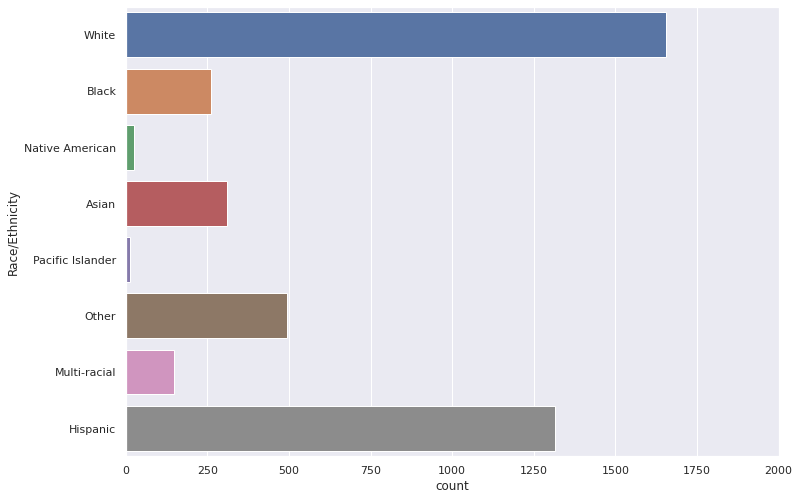

In [202]:
# race count in southern san diego official polling locations

sns.set(rc={'figure.figsize':(11.7,8.27)})
y_columns_race = ['White', 'Black', 'Native American', 'Asian', 'Pacific Islander', 'Other', 'Multi-racial', 'Hispanic']
ax = sns.barplot(x=south_polling_locations_sdf[race_columns].sum().values, y=y_columns_race)
ax.set(xlabel='count', ylabel='Race/Ethnicity')
ax.set(xlim=(0, 2000))


[(0.0, 600.0)]

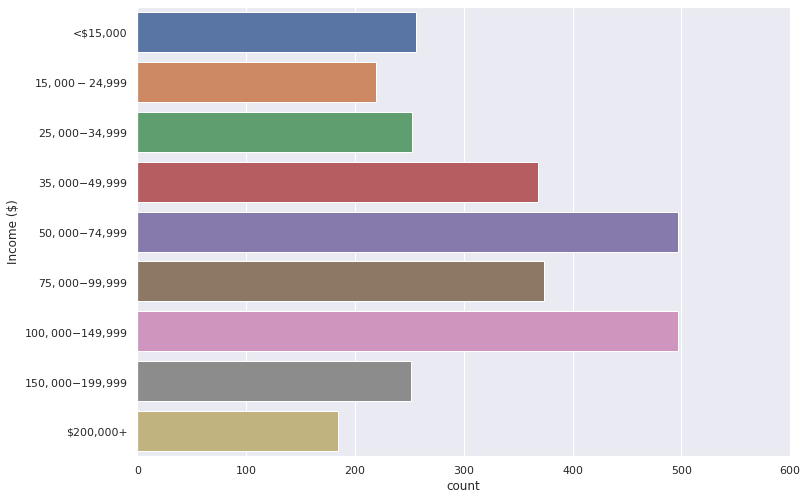

In [213]:
# income count in southern san diego official polling locations

sns.set(rc={'figure.figsize':(11.7,8.27)})
y_columns_income = ['<$15,000', '$15,000 - $24,999', '$25,000−$34,999', '$35,000−$49,999', '$50,000−$74,999', '$75,000−$99,999', '$100,000−$149,999', '$150,000−$199,999', '$200,000+']
ax = sns.barplot(x=south_polling_locations_sdf[income_columns].sum().values, y=y_columns_income)
ax.set(xlabel='count', ylabel='Income ($)')
ax.set(xlim=(0, 600))


In [181]:
# get a list of southern polling locations after location-allocations
southern_localloc_locations = agol.content.get('f91673b08ca0444095af96dbfb0438ca').layers[0].query().sdf
southern_localloc_locations = southern_localloc_locations[southern_localloc_locations['FacilityType'] == 'Chosen']

points = southern_localloc_locations['SnapX'].astype(str) +  ',' + southern_localloc_locations['SnapY'].astype(str)
points = list(points.values)

# enrich the study area with SnapX and SnapY for the same criteria listed above
south_localloc_locations_sdf = dissolved_polling_locations_sdf[:0] # initialize a blank sdf

for i in relevant_columns:
    south_localloc_locations_sdf[i] = 0
    
# geoenrich them with age, income, and race
for i in points:
    add_stats = enrich(study_areas=[str(i)], data_collections=['Age', 'RaceAndEthnicity', 'HouseholdsByIncome'])[relevant_columns]
    
    for j in add_stats.columns:
        south_localloc_locations_sdf.loc[i, j] = add_stats[j][0]
    
south_localloc_locations_sdf.head(2)  

-117.11655,32.57691722
-116.9679891,32.56246
-116.9990145,32.63929575
-117.06189,32.57903
-117.10605,32.57786
-117.04446,32.5811
-116.97475,32.61107
-117.05671,32.61495
-117.06364,32.63199
-117.07742763,32.60967441
-117.04539,32.55782
-117.05627486,32.60097432
-117.02685786,32.63167111
-117.10717767,32.66086021
-117.08165,32.57144
-117.0781353,32.58013
-117.00639699,32.58174548
-117.02221044,32.61471904
-117.0973804,32.62095992
-117.13478353,32.62073869
-117.00263791,32.62556405
-116.94162531,32.63224789
-116.97957,32.63647
-117.07767739,32.64140522
-116.98989361,32.64715477
-117.02792489,32.64870617
-117.08953952,32.64809168
-117.04960305,32.54561944
-117.02823538,32.60203226
-117.03257781,32.61963458
-117.01174273,32.63046463


OBJECTID FULLADD  Count_  AnalysisArea SHAPE  MALE20  \
-117.11655,32.57691722       NaN     NaN     NaN           NaN  None  1341.0   
-116.9679891,32.56246        NaN     NaN     NaN           NaN  None     3.0   

                        MALE25  MALE30  MALE35  MALE40  ...  HISPPOP_CY_P  \
-117.11655,32.57691722  1578.0  1406.0  1094.0   785.0  ...         54.08   
-116.9679891,32.56246      3.0     3.0     2.0     2.0  ...         84.51   

                        HINC0_CY_P  HINC15_CY_P  HINC25_CY_P  HINC35_CY_P  \
-117.11655,32.57691722        10.0          8.0          9.4         16.0   
-116.9679891,32.56246          4.3          4.3          4.3          4.3   

                        HINC50_CY_P  HINC75_CY_P  HINC100_CY_P  HINC150_CY_P  \
-117.11655,32.57691722         20.4         14.6          12.6           5.3   
-116.9679891,32.56246          17.4         21.7          26.1          13.0   

                        HINC200_CY_P  
-117.11655,32.57691722           3.9  
-116.9679891,32.56246            4.3  

[2 rows x 50 columns]

[Text(0, 0.5, 'Gender, Age'), Text(0.5, 0, 'count')]

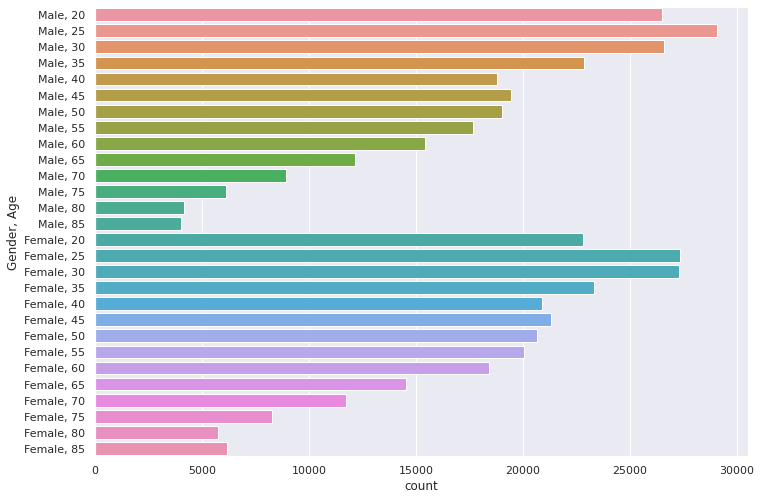

In [214]:
# age count in southern san diego location-allocation polling locations

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=south_localloc_locations_sdf[age_columns].sum().values, y=y_columns_age)
ax.set(xlabel='count', ylabel='Gender, Age')


[Text(0, 0.5, 'Race/Ethnicity'), Text(0.5, 0, 'count')]

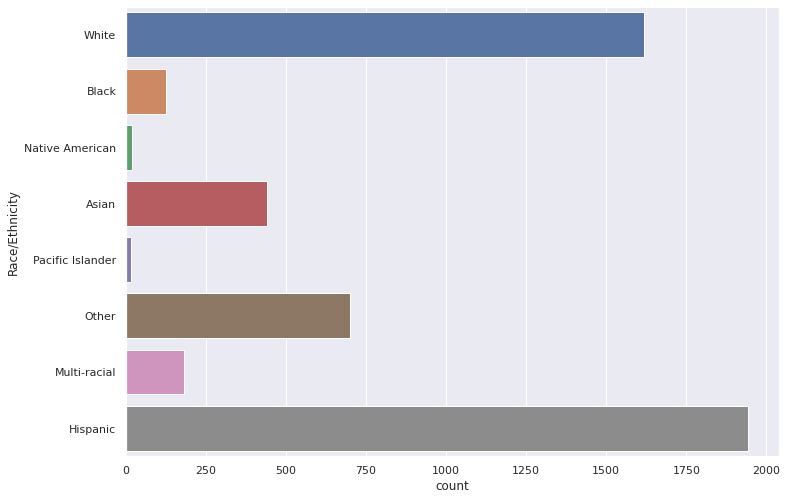

In [215]:
# race count in southern san diego location-allocations polling locations

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=south_localloc_locations_sdf[race_columns].sum().values, y=y_columns_race)
ax.set(xlabel='count', ylabel='Race/Ethnicity')


[Text(0, 0.5, 'Income ($)'), Text(0.5, 0, 'count')]

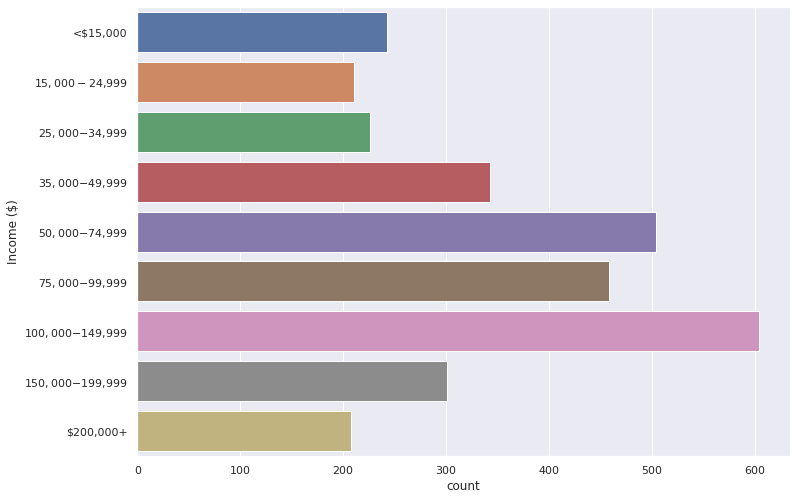

In [216]:
# income count in southern san diego location-allocation polling locations

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=south_localloc_locations_sdf[income_columns].sum().values, y=y_columns_income)
ax.set(xlabel='count', ylabel='Income ($)')


__Reflecting on our analysis:__
The steps we took ended up being a little different from our proposal. For example, we decided to geoenrich not on a zipcode scale, but rather on each address to have more accuracy in visualizing what changed in the characteristics of the polling locations. Our geoenrichment results will also need to be more refined, since we were limited on time we spent most of our time on the location-allocation and data cleaning and didn’t get to spend too much time on researching different ways we can geoenrich our layers. Another example is we did not end up analyzing COVID cases in the area since we didn’t have the time to implement COVID data into our Location-Allocation task and we figured that our solution would be more adaptable for future elections if we did not use COVID data. 


# Summary of products and results<a class="anchor" id="summary"></a>

As you can see in our map titled "webmap_results", polling station locations after location-allocations differ from that of the official polling locations. We can see that multiple polling locations are placed strategically with the location-allocation algorithm in a way to be accomodating to multiple precinct centroids. We weren't able to  perform location-allocation on the whole county since ArcGIS Online limits us to 1,000 candidates points (we had 2,000+), but we did weight our locations by the rate on non-vbm voters. This is important because we have shown another way of being able to locate polling station locations that doesn't involve randomly placing them. We could also extend this project to non-COVID elections by taking out many of the restrictions we used to apply the filter to the Land Use layer and developing more candidate locations that are viable to be a polling location. 

As you can see in our geonenrichment graphs, the age, income, and race categories also change between the official locations and our locations determined by location-allocation. For example, in the race graphs we shift to a more Hispanic population. This is also important because this means that we can further play with the project to equalize those graphs and possibly try to represent all kinds of voters. However, this would involve analysis between the rate of voters and those demographics in San Diego that we'd need further time to complete. 

This is the output of all 5 of the location-allocation sub regions combined into an interactive webmap.

In [27]:
webmap_results = agol.content.get('fca1d5436d5d457c92fd03da03f74355')
WebMap(webmap_results)

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

We can see that our locations were different than that of the official 2020 polling station locations! The orange smybols represent the current polling locations in San Diego County, and the squares represent our new polling locations (__Green: South San Diego, Red: Central San Diego, Blue: La Jolla/UCSD Region, Purple: Del Mar/Encinitas Region, Yellow: North San Diego__) We can also see the demand points (which precinct it is assigned to) that are being allocated to the new polling locations represented by the dots being connected by lines to the squares.

# Discussion  <a class="anchor" id="disc"></a>

__1)__ In the context of what is already known, we can see that we are able to use GIS to improve the placement of San Diego county’s polling locations to take voter registration data into account. We can replicate the number of polling stations per area as well as take different restrictions into account. Like the article titled “COVID-19: Location Intelligence Guides Adaptation of Voting Practices” implied, we may be moving towards an era where GIS helps determine polling locations. 

__2)__ Although this was previously stated, a huge trade-off was that we had to largely reduce the number of candidate locations to try to run location-allocation on the whole county. When it was obvious that we wouldn’t be able to reduce the candidate locations down to 1,000 (which is the maximum amount of candidate locations you can have according to AGOL), we chose to reduce it only as much as possible and then run location-allocation on different subsets of the city. When performing geoenrichment, we also found that many addresses from the official polling station locations could not be found, so I have to geoenrich at the zip code level instead. This could lead to possible inconsistencies in the graph counts. Additionally, in this project since we used only government owned locations as candidate locations so we can assume that these locations are usable. However, if we took into account residential areas or private locations when performing location-allocation, we wouldn’t have a sure way of determining whether owners of these locations would agree to hosting polling locations. So if this project is expanded, we’d have to take that into consideration. Another option we could consider in the future is to recalculate the demand points to more accurately represent that precinct's population of registered voters by determining hotspots of the voters and assign points into those hotspots instead of just calculating the centroid of a precinct, however this would require us to get more spatial data such as the addresses of the voters which might pose certain data privacy issues.


# Conclusion<a class="anchor" id="conclusion"></a>

__Proposed Solutions and Caveats__

Our project conveys a solution to the obsolete system of choosing in-person polling locations. Due to the unpredictable events this 2020 presidential election posed, we were inspired to create a new system for San Diego county to select new polling locations using GIS tools to optimize the polling locations.  Due to our time constraints of this project, the project comes with some caveats. First, we were not able to explore much of the ‘demand points weights’ in our algorithm, we only chose one weight factor which was the rate of registered non vote-by-mail voters for the precinct. Second, we took only a subset of all of San Diego County, due to the large size of the datasets and insufficient computing power, leading to an incomplete location-allocation analysis of the whole county. Because of these caveats, we were unable to propose new polling locations that had a clear meaningful impact to the whole population of voters. 

__Future Implementations__

For future implementations, we could also expand this project to include not only the subsets of San Diego County that we used for our analysis, but rather the whole county as input data. We could even scale this project to a state-wide level, or national-level. For future renditions of our algorithm, we plan to utilize a multitude of different weight factors for our demand points to come to a solution that will be able to take into consideration multiple factors that affect in-person voting turnout such as the accessibility/landscape of a location, crime rate and safeness level, demographics of voters to ensure equal opportunities for all races/income group to vote, and the list goes on. We can also adapt our system to predict future elections outside of the current pandemic. To do this we will create a new model that will be created based on past elections data (could be implemented with machine learning) and be highly adaptable to new data and situations in the future.

__Ending Discussion__

This project still has a lot of room for improvement and growth, with more research and time put into refining the project, we will be able to greatly reduce the time it takes to choose new polling locations in San Diego in the time of an election, and the resulting locations will foster the growth of in-person voting and maximize voter participation as well as voter confidence. We hope that this project will allow the residents of San Diego County to have their voices be accurately heard and better represented.


# Back to top [Click Here](#toc)